# INM707 Coursework

## Ho Yin Tam

## Basic

Import the library

In [123]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import pygame
from collections import deque
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.env import EnvContext
from ray.rllib.algorithms.sac.sac_tf_policy import SACTFPolicy

### Define the environment and perform Q learning.

In [73]:
simulated_warehouse_environment = np.full((10,10), -1)

# Set the top right corner as the target destination with a reward of 100
simulated_warehouse_environment[0,9] = 100

# Set the shelve with the reward of -100
simulated_warehouse_environment[0,3] = -100

simulated_warehouse_environment[1,1] = -100
simulated_warehouse_environment[1,2] = -100
simulated_warehouse_environment[1,3] = -100
simulated_warehouse_environment[1,5] = -100
simulated_warehouse_environment[1,6] = -100
simulated_warehouse_environment[1,7] = -100
simulated_warehouse_environment[1,8] = -100

simulated_warehouse_environment[2,5] = -100

simulated_warehouse_environment[3,0] = -100
simulated_warehouse_environment[3,1] = -100
simulated_warehouse_environment[3,2] = -100
simulated_warehouse_environment[3,4] = -100
simulated_warehouse_environment[3,9] = -100
simulated_warehouse_environment[3,8] = -100
simulated_warehouse_environment[3,7] = -100

simulated_warehouse_environment[4,2] = -100
simulated_warehouse_environment[4,4] = -100
simulated_warehouse_environment[4,6] = -100
simulated_warehouse_environment[4,7] = -100

simulated_warehouse_environment[5,4] = -100

simulated_warehouse_environment[6,0] = -100
simulated_warehouse_environment[6,1] = -100
simulated_warehouse_environment[6,2] = -100
simulated_warehouse_environment[6,4] = -100
simulated_warehouse_environment[6,5] = -100
simulated_warehouse_environment[6,6] = -100
simulated_warehouse_environment[6,8] = -100
simulated_warehouse_environment[6,9] = -100

simulated_warehouse_environment[7,2] = -100
simulated_warehouse_environment[7,9] = -100

simulated_warehouse_environment[8,1] = -100
simulated_warehouse_environment[8,2] = -100
simulated_warehouse_environment[8,3] = -100
simulated_warehouse_environment[8,4] = -100
simulated_warehouse_environment[8,6] = -100
simulated_warehouse_environment[8,7] = -100
simulated_warehouse_environment[8,8] = -100
simulated_warehouse_environment[8,9] = -100

print(simulated_warehouse_environment)

[[  -1   -1   -1 -100   -1   -1   -1   -1   -1  100]
 [  -1 -100 -100 -100   -1 -100 -100 -100 -100   -1]
 [  -1   -1   -1   -1   -1 -100   -1   -1   -1   -1]
 [-100 -100 -100   -1 -100   -1   -1 -100 -100 -100]
 [  -1   -1 -100   -1 -100   -1 -100 -100   -1   -1]
 [  -1   -1   -1   -1 -100   -1   -1   -1   -1   -1]
 [-100 -100 -100   -1 -100 -100 -100   -1 -100 -100]
 [  -1   -1 -100   -1   -1   -1   -1   -1   -1 -100]
 [  -1 -100 -100 -100 -100   -1 -100 -100 -100 -100]
 [  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1]]


Episode 1: Total Reward = -183
Episode 2: Total Reward = -268
Episode 3: Total Reward = -1000
Episode 4: Total Reward = -340
Episode 5: Total Reward = -211
Episode 6: Total Reward = -445
Episode 7: Total Reward = -226
Episode 8: Total Reward = -321
Episode 9: Total Reward = -114
Episode 10: Total Reward = -344
Episode 11: Total Reward = -149
Episode 12: Total Reward = -330
Episode 13: Total Reward = -119
Episode 14: Total Reward = -228
Episode 15: Total Reward = -50
Episode 16: Total Reward = -170
Episode 17: Total Reward = -185
Episode 18: Total Reward = -160
Episode 19: Total Reward = -151
Episode 20: Total Reward = -74
Episode 21: Total Reward = -189
Episode 22: Total Reward = -89
Episode 23: Total Reward = -70
Episode 24: Total Reward = -119
Episode 25: Total Reward = -97
Episode 26: Total Reward = -197
Episode 27: Total Reward = -16
Episode 28: Total Reward = -57
Episode 29: Total Reward = -64
Episode 30: Total Reward = -79
Episode 31: Total Reward = -52
Episode 32: Total Reward =

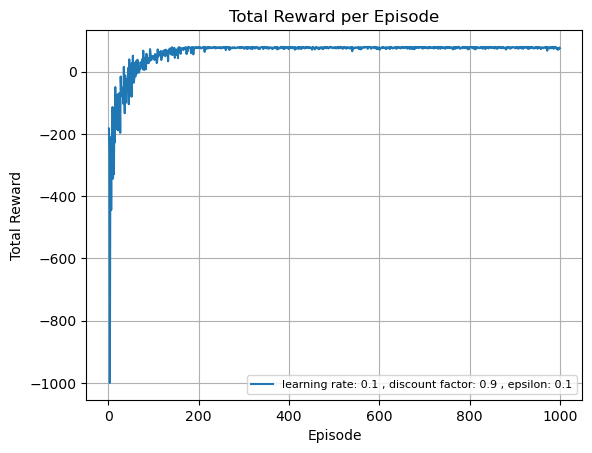

In [132]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

### Experiment wth different learning rate or alpha.

#### Learning rate = 0.01

Episode 1: Total Reward = -381
Episode 2: Total Reward = -380
Episode 3: Total Reward = -1000
Episode 4: Total Reward = -452
Episode 5: Total Reward = -306
Episode 6: Total Reward = -1000
Episode 7: Total Reward = -1000
Episode 8: Total Reward = -385
Episode 9: Total Reward = -307
Episode 10: Total Reward = -1000
Episode 11: Total Reward = -790
Episode 12: Total Reward = -153
Episode 13: Total Reward = -1000
Episode 14: Total Reward = -317
Episode 15: Total Reward = -1000
Episode 16: Total Reward = -90
Episode 17: Total Reward = -851
Episode 18: Total Reward = -204
Episode 19: Total Reward = -1000
Episode 20: Total Reward = -30
Episode 21: Total Reward = -275
Episode 22: Total Reward = -1000
Episode 23: Total Reward = -93
Episode 24: Total Reward = -354
Episode 25: Total Reward = -502
Episode 26: Total Reward = -545
Episode 27: Total Reward = -369
Episode 28: Total Reward = -549
Episode 29: Total Reward = -444
Episode 30: Total Reward = -451
Episode 31: Total Reward = -389
Episode 32: 

Episode 299: Total Reward = -73
Episode 300: Total Reward = -41
Episode 301: Total Reward = -185
Episode 302: Total Reward = -4
Episode 303: Total Reward = -37
Episode 304: Total Reward = -33
Episode 305: Total Reward = -61
Episode 306: Total Reward = -43
Episode 307: Total Reward = -20
Episode 308: Total Reward = -43
Episode 309: Total Reward = -88
Episode 310: Total Reward = -25
Episode 311: Total Reward = -57
Episode 312: Total Reward = 10
Episode 313: Total Reward = -70
Episode 314: Total Reward = -39
Episode 315: Total Reward = -101
Episode 316: Total Reward = -29
Episode 317: Total Reward = -72
Episode 318: Total Reward = -41
Episode 319: Total Reward = -80
Episode 320: Total Reward = -24
Episode 321: Total Reward = -107
Episode 322: Total Reward = -20
Episode 323: Total Reward = -95
Episode 324: Total Reward = -25
Episode 325: Total Reward = 0
Episode 326: Total Reward = 25
Episode 327: Total Reward = -90
Episode 328: Total Reward = -40
Episode 329: Total Reward = -106
Episode 3

Episode 671: Total Reward = 25
Episode 672: Total Reward = 44
Episode 673: Total Reward = 1
Episode 674: Total Reward = 36
Episode 675: Total Reward = 40
Episode 676: Total Reward = 17
Episode 677: Total Reward = -7
Episode 678: Total Reward = 23
Episode 679: Total Reward = 10
Episode 680: Total Reward = 55
Episode 681: Total Reward = 26
Episode 682: Total Reward = -2
Episode 683: Total Reward = 44
Episode 684: Total Reward = 47
Episode 685: Total Reward = 17
Episode 686: Total Reward = 32
Episode 687: Total Reward = 24
Episode 688: Total Reward = -11
Episode 689: Total Reward = 31
Episode 690: Total Reward = 24
Episode 691: Total Reward = 31
Episode 692: Total Reward = 37
Episode 693: Total Reward = 43
Episode 694: Total Reward = 32
Episode 695: Total Reward = 14
Episode 696: Total Reward = 6
Episode 697: Total Reward = 23
Episode 698: Total Reward = 49
Episode 699: Total Reward = 31
Episode 700: Total Reward = 50
Episode 701: Total Reward = 18
Episode 702: Total Reward = 42
Episode 7

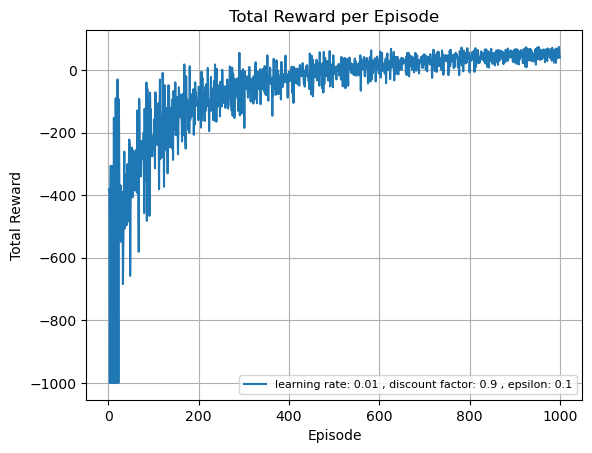

In [159]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.01
discount_factor = 0.9
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_alpha1 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_alpha1, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

#### Learning rate = 0.1

Episode 1: Total Reward = -489
Episode 2: Total Reward = -125
Episode 3: Total Reward = -1000
Episode 4: Total Reward = -161
Episode 5: Total Reward = -287
Episode 6: Total Reward = -202
Episode 7: Total Reward = -495
Episode 8: Total Reward = -221
Episode 9: Total Reward = -300
Episode 10: Total Reward = -253
Episode 11: Total Reward = -270
Episode 12: Total Reward = -116
Episode 13: Total Reward = -243
Episode 14: Total Reward = -171
Episode 15: Total Reward = -293
Episode 16: Total Reward = -190
Episode 17: Total Reward = -86
Episode 18: Total Reward = -146
Episode 19: Total Reward = -113
Episode 20: Total Reward = -63
Episode 21: Total Reward = -172
Episode 22: Total Reward = -106
Episode 23: Total Reward = -140
Episode 24: Total Reward = -66
Episode 25: Total Reward = -186
Episode 26: Total Reward = -134
Episode 27: Total Reward = -39
Episode 28: Total Reward = -49
Episode 29: Total Reward = -75
Episode 30: Total Reward = -42
Episode 31: Total Reward = -54
Episode 32: Total Reward

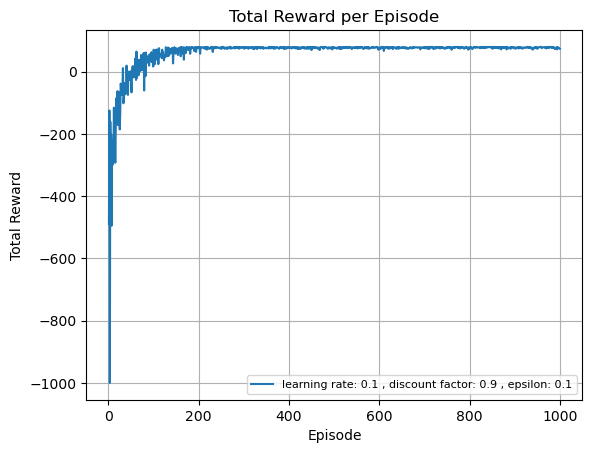

In [138]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_alpha2 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_alpha2, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

#### Learning rate = 0.9

Episode 1: Total Reward = -167
Episode 2: Total Reward = -199
Episode 3: Total Reward = -35
Episode 4: Total Reward = -238
Episode 5: Total Reward = 27
Episode 6: Total Reward = -46
Episode 7: Total Reward = -23
Episode 8: Total Reward = -94
Episode 9: Total Reward = 13
Episode 10: Total Reward = -97
Episode 11: Total Reward = 27
Episode 12: Total Reward = 12
Episode 13: Total Reward = 5
Episode 14: Total Reward = 60
Episode 15: Total Reward = -5
Episode 16: Total Reward = 13
Episode 17: Total Reward = 49
Episode 18: Total Reward = 32
Episode 19: Total Reward = 24
Episode 20: Total Reward = 60
Episode 21: Total Reward = -34
Episode 22: Total Reward = 26
Episode 23: Total Reward = 37
Episode 24: Total Reward = 68
Episode 25: Total Reward = 77
Episode 26: Total Reward = 71
Episode 27: Total Reward = 61
Episode 28: Total Reward = 72
Episode 29: Total Reward = 74
Episode 30: Total Reward = 67
Episode 31: Total Reward = 30
Episode 32: Total Reward = 75
Episode 33: Total Reward = 78
Episode 

Episode 537: Total Reward = 78
Episode 538: Total Reward = 77
Episode 539: Total Reward = 77
Episode 540: Total Reward = 79
Episode 541: Total Reward = 77
Episode 542: Total Reward = 75
Episode 543: Total Reward = 75
Episode 544: Total Reward = 77
Episode 545: Total Reward = 74
Episode 546: Total Reward = 78
Episode 547: Total Reward = 72
Episode 548: Total Reward = 75
Episode 549: Total Reward = 74
Episode 550: Total Reward = 79
Episode 551: Total Reward = 77
Episode 552: Total Reward = 76
Episode 553: Total Reward = 76
Episode 554: Total Reward = 73
Episode 555: Total Reward = 78
Episode 556: Total Reward = 79
Episode 557: Total Reward = 78
Episode 558: Total Reward = 73
Episode 559: Total Reward = 77
Episode 560: Total Reward = 79
Episode 561: Total Reward = 79
Episode 562: Total Reward = 75
Episode 563: Total Reward = 78
Episode 564: Total Reward = 78
Episode 565: Total Reward = 77
Episode 566: Total Reward = 76
Episode 567: Total Reward = 79
Episode 568: Total Reward = 78
Episode 

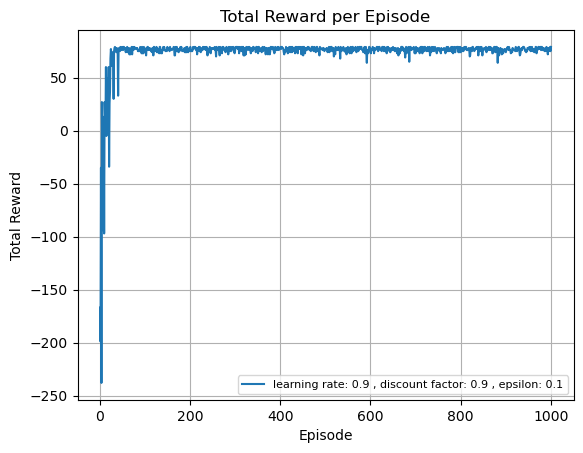

In [140]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.9
discount_factor = 0.9
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_alpha3 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_alpha3, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

#### Plot all these three together for the ease of comparison.

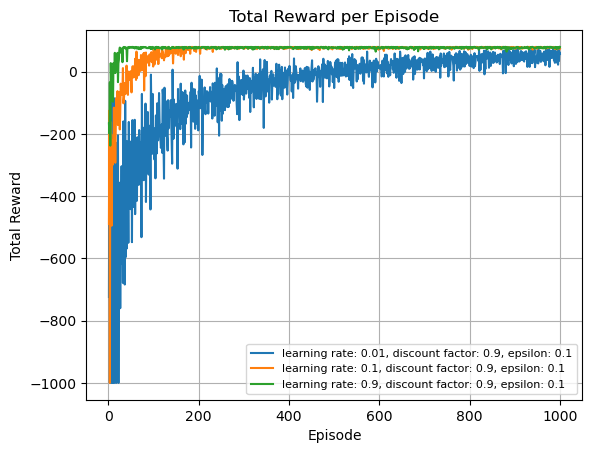

In [141]:
# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_alpha1, label = 'learning rate: 0.01, discount factor: 0.9, epsilon: 0.1')
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_alpha2, label = 'learning rate: 0.1, discount factor: 0.9, epsilon: 0.1')
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_alpha3, label = 'learning rate: 0.9, discount factor: 0.9, epsilon: 0.1')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

### Experiment wth different discount factor or gamma.

Discount factor = 0.1.

Episode 1: Total Reward = -298
Episode 2: Total Reward = -369
Episode 3: Total Reward = -1000
Episode 4: Total Reward = -885
Episode 5: Total Reward = -619
Episode 6: Total Reward = -807
Episode 7: Total Reward = -630
Episode 8: Total Reward = -1000
Episode 9: Total Reward = -761
Episode 10: Total Reward = -268
Episode 11: Total Reward = -829
Episode 12: Total Reward = -286
Episode 13: Total Reward = -1000
Episode 14: Total Reward = -326
Episode 15: Total Reward = -1000
Episode 16: Total Reward = -175
Episode 17: Total Reward = -367
Episode 18: Total Reward = -307
Episode 19: Total Reward = -665
Episode 20: Total Reward = -256
Episode 21: Total Reward = -640
Episode 22: Total Reward = -174
Episode 23: Total Reward = -1000
Episode 24: Total Reward = -65
Episode 25: Total Reward = -337
Episode 26: Total Reward = -266
Episode 27: Total Reward = -451
Episode 28: Total Reward = -188
Episode 29: Total Reward = -452
Episode 30: Total Reward = -360
Episode 31: Total Reward = -350
Episode 32: T

Episode 261: Total Reward = -1000
Episode 262: Total Reward = -1000
Episode 263: Total Reward = -1000
Episode 264: Total Reward = -1000
Episode 265: Total Reward = -1000
Episode 266: Total Reward = -1000
Episode 267: Total Reward = -1000
Episode 268: Total Reward = -1000
Episode 269: Total Reward = -1000
Episode 270: Total Reward = -1000
Episode 271: Total Reward = -1000
Episode 272: Total Reward = -1000
Episode 273: Total Reward = -1000
Episode 274: Total Reward = -1000
Episode 275: Total Reward = -1000
Episode 276: Total Reward = 28
Episode 277: Total Reward = -1000
Episode 278: Total Reward = -1000
Episode 279: Total Reward = -1000
Episode 280: Total Reward = -1000
Episode 281: Total Reward = -1000
Episode 282: Total Reward = -1000
Episode 283: Total Reward = -1000
Episode 284: Total Reward = -1000
Episode 285: Total Reward = -1000
Episode 286: Total Reward = -1000
Episode 287: Total Reward = -1000
Episode 288: Total Reward = -1000
Episode 289: Total Reward = -1000
Episode 290: Tota

Episode 516: Total Reward = -1000
Episode 517: Total Reward = -1000
Episode 518: Total Reward = -1000
Episode 519: Total Reward = -1000
Episode 520: Total Reward = -1000
Episode 521: Total Reward = -1000
Episode 522: Total Reward = -1000
Episode 523: Total Reward = -1000
Episode 524: Total Reward = -1000
Episode 525: Total Reward = -1000
Episode 526: Total Reward = -1000
Episode 527: Total Reward = -1000
Episode 528: Total Reward = -1000
Episode 529: Total Reward = -1000
Episode 530: Total Reward = -1000
Episode 531: Total Reward = -1000
Episode 532: Total Reward = -1000
Episode 533: Total Reward = -1000
Episode 534: Total Reward = -1000
Episode 535: Total Reward = -1000
Episode 536: Total Reward = -1000
Episode 537: Total Reward = -1000
Episode 538: Total Reward = -1000
Episode 539: Total Reward = -1000
Episode 540: Total Reward = -1000
Episode 541: Total Reward = -1000
Episode 542: Total Reward = -1000
Episode 543: Total Reward = -1000
Episode 544: Total Reward = -1000
Episode 545: T

Episode 775: Total Reward = -1000
Episode 776: Total Reward = -1000
Episode 777: Total Reward = -1000
Episode 778: Total Reward = -1000
Episode 779: Total Reward = -1000
Episode 780: Total Reward = -1000
Episode 781: Total Reward = -1000
Episode 782: Total Reward = -1000
Episode 783: Total Reward = -1000
Episode 784: Total Reward = -1000
Episode 785: Total Reward = -1000
Episode 786: Total Reward = -1000
Episode 787: Total Reward = -1000
Episode 788: Total Reward = -1000
Episode 789: Total Reward = -1000
Episode 790: Total Reward = -1000
Episode 791: Total Reward = -1000
Episode 792: Total Reward = -1000
Episode 793: Total Reward = -1000
Episode 794: Total Reward = -1000
Episode 795: Total Reward = -1000
Episode 796: Total Reward = -1000
Episode 797: Total Reward = -1
Episode 798: Total Reward = -1000
Episode 799: Total Reward = -1000
Episode 800: Total Reward = -1000
Episode 801: Total Reward = -1000
Episode 802: Total Reward = -1000
Episode 803: Total Reward = -1000
Episode 804: Tota

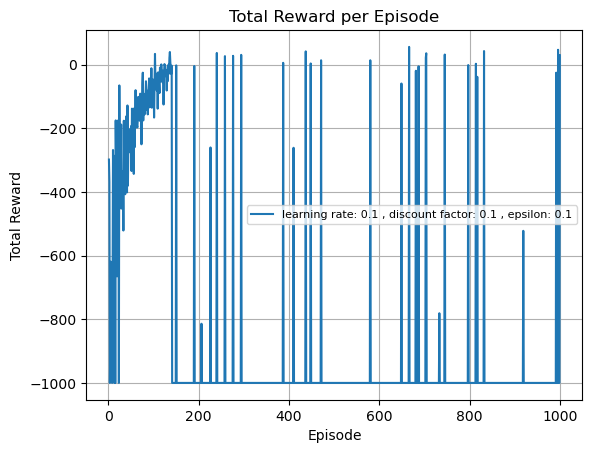

In [146]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.1
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_gamma1 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_gamma1, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

Discount factor = 0.5.

Episode 1: Total Reward = -364
Episode 2: Total Reward = -219
Episode 3: Total Reward = -1000
Episode 4: Total Reward = -369
Episode 5: Total Reward = -239
Episode 6: Total Reward = -628
Episode 7: Total Reward = -370
Episode 8: Total Reward = -403
Episode 9: Total Reward = -327
Episode 10: Total Reward = -261
Episode 11: Total Reward = -274
Episode 12: Total Reward = -441
Episode 13: Total Reward = -275
Episode 14: Total Reward = -427
Episode 15: Total Reward = -40
Episode 16: Total Reward = -382
Episode 17: Total Reward = -214
Episode 18: Total Reward = -87
Episode 19: Total Reward = -190
Episode 20: Total Reward = -227
Episode 21: Total Reward = -76
Episode 22: Total Reward = -232
Episode 23: Total Reward = -180
Episode 24: Total Reward = -240
Episode 25: Total Reward = -166
Episode 26: Total Reward = -91
Episode 27: Total Reward = -216
Episode 28: Total Reward = -81
Episode 29: Total Reward = -68
Episode 30: Total Reward = -250
Episode 31: Total Reward = -73
Episode 32: Total Rewar

Episode 285: Total Reward = 78
Episode 286: Total Reward = 74
Episode 287: Total Reward = 74
Episode 288: Total Reward = 79
Episode 289: Total Reward = 75
Episode 290: Total Reward = 79
Episode 291: Total Reward = 77
Episode 292: Total Reward = 74
Episode 293: Total Reward = 73
Episode 294: Total Reward = 79
Episode 295: Total Reward = 79
Episode 296: Total Reward = 76
Episode 297: Total Reward = 74
Episode 298: Total Reward = 79
Episode 299: Total Reward = 79
Episode 300: Total Reward = 77
Episode 301: Total Reward = 79
Episode 302: Total Reward = 77
Episode 303: Total Reward = 76
Episode 304: Total Reward = 76
Episode 305: Total Reward = 75
Episode 306: Total Reward = 76
Episode 307: Total Reward = 77
Episode 308: Total Reward = 76
Episode 309: Total Reward = 73
Episode 310: Total Reward = 79
Episode 311: Total Reward = 78
Episode 312: Total Reward = 75
Episode 313: Total Reward = 77
Episode 314: Total Reward = 74
Episode 315: Total Reward = 76
Episode 316: Total Reward = 76
Episode 

Episode 739: Total Reward = 78
Episode 740: Total Reward = 74
Episode 741: Total Reward = 74
Episode 742: Total Reward = 77
Episode 743: Total Reward = 73
Episode 744: Total Reward = 77
Episode 745: Total Reward = 78
Episode 746: Total Reward = 77
Episode 747: Total Reward = 79
Episode 748: Total Reward = 77
Episode 749: Total Reward = 72
Episode 750: Total Reward = 78
Episode 751: Total Reward = 74
Episode 752: Total Reward = 78
Episode 753: Total Reward = 79
Episode 754: Total Reward = 78
Episode 755: Total Reward = 72
Episode 756: Total Reward = 79
Episode 757: Total Reward = 77
Episode 758: Total Reward = 79
Episode 759: Total Reward = 75
Episode 760: Total Reward = 79
Episode 761: Total Reward = 76
Episode 762: Total Reward = 75
Episode 763: Total Reward = 79
Episode 764: Total Reward = 78
Episode 765: Total Reward = 72
Episode 766: Total Reward = 78
Episode 767: Total Reward = 74
Episode 768: Total Reward = 77
Episode 769: Total Reward = 77
Episode 770: Total Reward = 72
Episode 

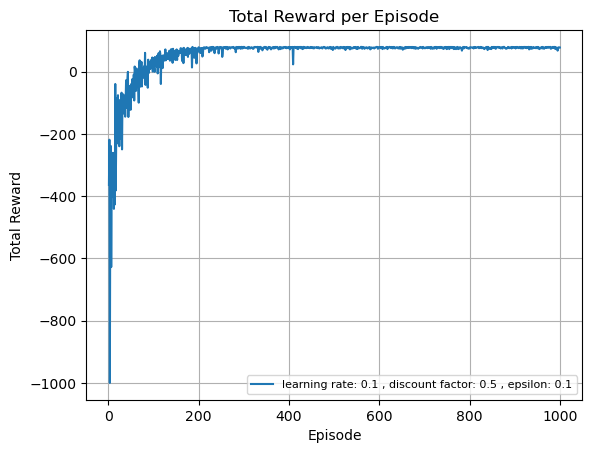

In [149]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.5
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_gamma2 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_gamma2, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

Discount factor = 0.9.

Episode 1: Total Reward = -549
Episode 2: Total Reward = -235
Episode 3: Total Reward = -820
Episode 4: Total Reward = -182
Episode 5: Total Reward = -797
Episode 6: Total Reward = -123
Episode 7: Total Reward = -275
Episode 8: Total Reward = -158
Episode 9: Total Reward = -198
Episode 10: Total Reward = -310
Episode 11: Total Reward = -173
Episode 12: Total Reward = -244
Episode 13: Total Reward = -182
Episode 14: Total Reward = -148
Episode 15: Total Reward = -78
Episode 16: Total Reward = -287
Episode 17: Total Reward = -102
Episode 18: Total Reward = -113
Episode 19: Total Reward = -113
Episode 20: Total Reward = -205
Episode 21: Total Reward = -96
Episode 22: Total Reward = -111
Episode 23: Total Reward = -93
Episode 24: Total Reward = -103
Episode 25: Total Reward = -83
Episode 26: Total Reward = -34
Episode 27: Total Reward = -95
Episode 28: Total Reward = -64
Episode 29: Total Reward = -69
Episode 30: Total Reward = -137
Episode 31: Total Reward = -28
Episode 32: Total Reward =

Episode 584: Total Reward = 74
Episode 585: Total Reward = 78
Episode 586: Total Reward = 77
Episode 587: Total Reward = 78
Episode 588: Total Reward = 78
Episode 589: Total Reward = 78
Episode 590: Total Reward = 78
Episode 591: Total Reward = 78
Episode 592: Total Reward = 77
Episode 593: Total Reward = 78
Episode 594: Total Reward = 78
Episode 595: Total Reward = 71
Episode 596: Total Reward = 76
Episode 597: Total Reward = 76
Episode 598: Total Reward = 76
Episode 599: Total Reward = 78
Episode 600: Total Reward = 78
Episode 601: Total Reward = 78
Episode 602: Total Reward = 79
Episode 603: Total Reward = 71
Episode 604: Total Reward = 68
Episode 605: Total Reward = 79
Episode 606: Total Reward = 77
Episode 607: Total Reward = 72
Episode 608: Total Reward = 73
Episode 609: Total Reward = 76
Episode 610: Total Reward = 76
Episode 611: Total Reward = 77
Episode 612: Total Reward = 70
Episode 613: Total Reward = 78
Episode 614: Total Reward = 69
Episode 615: Total Reward = 72
Episode 

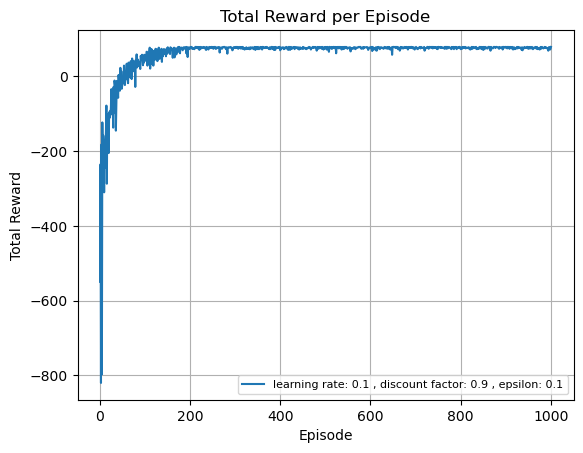

In [148]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_gamma3 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_gamma3, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

#### Plot all these three together for the ease of comparison.

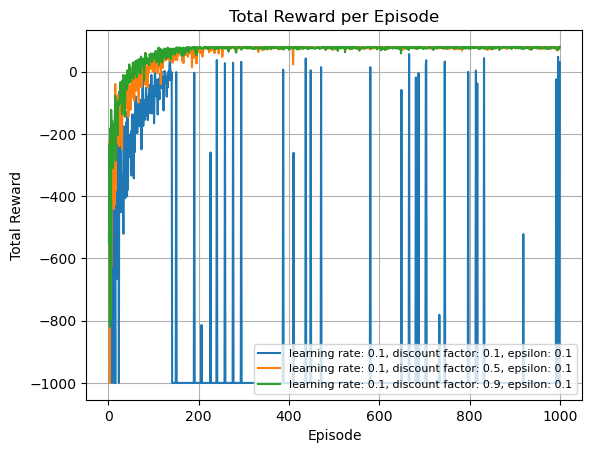

In [151]:
# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_gamma1, label = 'learning rate: 0.1, discount factor: 0.1, epsilon: 0.1')
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_gamma2, label = 'learning rate: 0.1, discount factor: 0.5, epsilon: 0.1')
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_gamma3, label = 'learning rate: 0.1, discount factor: 0.9, epsilon: 0.1')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8', loc = 'lower right')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

### Experiment wth different epsilon.

#### Epsilon = 0.1.

Episode 1: Total Reward = -372
Episode 2: Total Reward = -302
Episode 3: Total Reward = -888
Episode 4: Total Reward = -104
Episode 5: Total Reward = -845
Episode 6: Total Reward = -91
Episode 7: Total Reward = -473
Episode 8: Total Reward = -204
Episode 9: Total Reward = -194
Episode 10: Total Reward = -162
Episode 11: Total Reward = -416
Episode 12: Total Reward = -21
Episode 13: Total Reward = -155
Episode 14: Total Reward = -247
Episode 15: Total Reward = -185
Episode 16: Total Reward = -58
Episode 17: Total Reward = -176
Episode 18: Total Reward = -104
Episode 19: Total Reward = -189
Episode 20: Total Reward = -111
Episode 21: Total Reward = -60
Episode 22: Total Reward = -133
Episode 23: Total Reward = -223
Episode 24: Total Reward = 16
Episode 25: Total Reward = -90
Episode 26: Total Reward = -133
Episode 27: Total Reward = -43
Episode 28: Total Reward = 10
Episode 29: Total Reward = -37
Episode 30: Total Reward = -96
Episode 31: Total Reward = -109
Episode 32: Total Reward = -1

Episode 543: Total Reward = 73
Episode 544: Total Reward = 79
Episode 545: Total Reward = 74
Episode 546: Total Reward = 79
Episode 547: Total Reward = 76
Episode 548: Total Reward = 73
Episode 549: Total Reward = 77
Episode 550: Total Reward = 78
Episode 551: Total Reward = 75
Episode 552: Total Reward = 79
Episode 553: Total Reward = 73
Episode 554: Total Reward = 78
Episode 555: Total Reward = 78
Episode 556: Total Reward = 77
Episode 557: Total Reward = 75
Episode 558: Total Reward = 78
Episode 559: Total Reward = 73
Episode 560: Total Reward = 79
Episode 561: Total Reward = 77
Episode 562: Total Reward = 74
Episode 563: Total Reward = 78
Episode 564: Total Reward = 74
Episode 565: Total Reward = 78
Episode 566: Total Reward = 69
Episode 567: Total Reward = 76
Episode 568: Total Reward = 78
Episode 569: Total Reward = 77
Episode 570: Total Reward = 77
Episode 571: Total Reward = 79
Episode 572: Total Reward = 73
Episode 573: Total Reward = 78
Episode 574: Total Reward = 78
Episode 

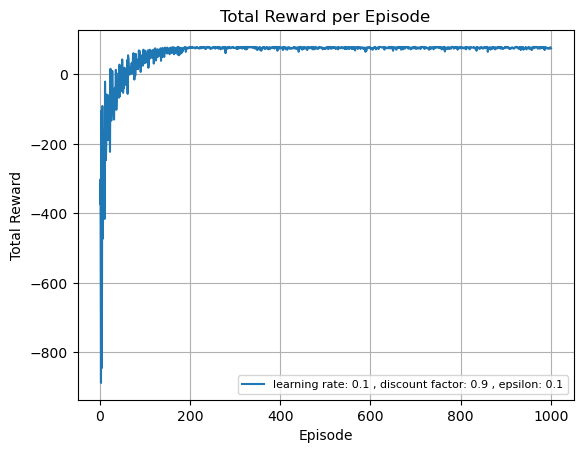

In [152]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_eps1 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_eps1, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

#### Epsilon = 0.5.

Episode 1: Total Reward = -422
Episode 2: Total Reward = -689
Episode 3: Total Reward = -505
Episode 4: Total Reward = -1000
Episode 5: Total Reward = -692
Episode 6: Total Reward = -15
Episode 7: Total Reward = -420
Episode 8: Total Reward = -332
Episode 9: Total Reward = -24
Episode 10: Total Reward = -571
Episode 11: Total Reward = 0
Episode 12: Total Reward = -279
Episode 13: Total Reward = -223
Episode 14: Total Reward = -225
Episode 15: Total Reward = 4
Episode 16: Total Reward = -119
Episode 17: Total Reward = -173
Episode 18: Total Reward = -99
Episode 19: Total Reward = -148
Episode 20: Total Reward = -113
Episode 21: Total Reward = -58
Episode 22: Total Reward = -103
Episode 23: Total Reward = -15
Episode 24: Total Reward = -196
Episode 25: Total Reward = -34
Episode 26: Total Reward = -82
Episode 27: Total Reward = -111
Episode 28: Total Reward = -202
Episode 29: Total Reward = -119
Episode 30: Total Reward = -3
Episode 31: Total Reward = 11
Episode 32: Total Reward = -78
Ep

Episode 788: Total Reward = 48
Episode 789: Total Reward = 54
Episode 790: Total Reward = 62
Episode 791: Total Reward = 58
Episode 792: Total Reward = 69
Episode 793: Total Reward = 69
Episode 794: Total Reward = 47
Episode 795: Total Reward = 46
Episode 796: Total Reward = 57
Episode 797: Total Reward = 60
Episode 798: Total Reward = 60
Episode 799: Total Reward = 31
Episode 800: Total Reward = 59
Episode 801: Total Reward = 58
Episode 802: Total Reward = 67
Episode 803: Total Reward = 47
Episode 804: Total Reward = 54
Episode 805: Total Reward = 60
Episode 806: Total Reward = 64
Episode 807: Total Reward = 68
Episode 808: Total Reward = 54
Episode 809: Total Reward = 59
Episode 810: Total Reward = 43
Episode 811: Total Reward = 60
Episode 812: Total Reward = 69
Episode 813: Total Reward = 67
Episode 814: Total Reward = 45
Episode 815: Total Reward = 56
Episode 816: Total Reward = 62
Episode 817: Total Reward = 53
Episode 818: Total Reward = 71
Episode 819: Total Reward = 66
Episode 

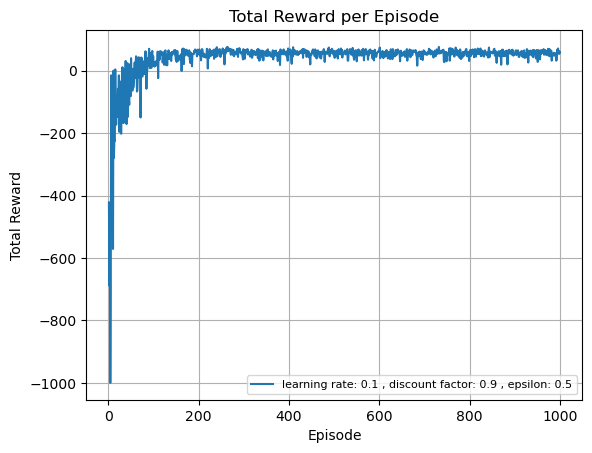

In [153]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.5

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_eps2 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_eps2, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

#### Epsilon = 0.9.

Episode 1: Total Reward = -1000
Episode 2: Total Reward = -326
Episode 3: Total Reward = -344
Episode 4: Total Reward = -1000
Episode 5: Total Reward = -834
Episode 6: Total Reward = -73
Episode 7: Total Reward = -833
Episode 8: Total Reward = -93
Episode 9: Total Reward = -1000
Episode 10: Total Reward = -552
Episode 11: Total Reward = -1000
Episode 12: Total Reward = -302
Episode 13: Total Reward = -602
Episode 14: Total Reward = -482
Episode 15: Total Reward = -145
Episode 16: Total Reward = -10
Episode 17: Total Reward = -425
Episode 18: Total Reward = -74
Episode 19: Total Reward = -235
Episode 20: Total Reward = -287
Episode 21: Total Reward = -214
Episode 22: Total Reward = -129
Episode 23: Total Reward = -1000
Episode 24: Total Reward = 31
Episode 25: Total Reward = -251
Episode 26: Total Reward = -323
Episode 27: Total Reward = -122
Episode 28: Total Reward = -433
Episode 29: Total Reward = -259
Episode 30: Total Reward = -130
Episode 31: Total Reward = -256
Episode 32: Total 

Episode 300: Total Reward = -197
Episode 301: Total Reward = -250
Episode 302: Total Reward = -242
Episode 303: Total Reward = -13
Episode 304: Total Reward = -118
Episode 305: Total Reward = -8
Episode 306: Total Reward = -105
Episode 307: Total Reward = -263
Episode 308: Total Reward = -92
Episode 309: Total Reward = -76
Episode 310: Total Reward = -90
Episode 311: Total Reward = -26
Episode 312: Total Reward = -136
Episode 313: Total Reward = -83
Episode 314: Total Reward = -222
Episode 315: Total Reward = 30
Episode 316: Total Reward = -36
Episode 317: Total Reward = 15
Episode 318: Total Reward = -61
Episode 319: Total Reward = -159
Episode 320: Total Reward = -177
Episode 321: Total Reward = -253
Episode 322: Total Reward = -106
Episode 323: Total Reward = -34
Episode 324: Total Reward = -119
Episode 325: Total Reward = -104
Episode 326: Total Reward = -228
Episode 327: Total Reward = -34
Episode 328: Total Reward = -300
Episode 329: Total Reward = -539
Episode 330: Total Reward 

Episode 600: Total Reward = -120
Episode 601: Total Reward = -334
Episode 602: Total Reward = -61
Episode 603: Total Reward = -98
Episode 604: Total Reward = -410
Episode 605: Total Reward = -38
Episode 606: Total Reward = -124
Episode 607: Total Reward = -265
Episode 608: Total Reward = -262
Episode 609: Total Reward = -247
Episode 610: Total Reward = -122
Episode 611: Total Reward = -44
Episode 612: Total Reward = -64
Episode 613: Total Reward = 24
Episode 614: Total Reward = -87
Episode 615: Total Reward = -84
Episode 616: Total Reward = 21
Episode 617: Total Reward = -7
Episode 618: Total Reward = -8
Episode 619: Total Reward = -276
Episode 620: Total Reward = -160
Episode 621: Total Reward = -200
Episode 622: Total Reward = -74
Episode 623: Total Reward = -288
Episode 624: Total Reward = -153
Episode 625: Total Reward = -138
Episode 626: Total Reward = -346
Episode 627: Total Reward = -161
Episode 628: Total Reward = -93
Episode 629: Total Reward = -119
Episode 630: Total Reward =

Episode 885: Total Reward = -250
Episode 886: Total Reward = -231
Episode 887: Total Reward = -153
Episode 888: Total Reward = -196
Episode 889: Total Reward = -74
Episode 890: Total Reward = -174
Episode 891: Total Reward = -28
Episode 892: Total Reward = -62
Episode 893: Total Reward = -173
Episode 894: Total Reward = -7
Episode 895: Total Reward = -111
Episode 896: Total Reward = -195
Episode 897: Total Reward = -325
Episode 898: Total Reward = -113
Episode 899: Total Reward = -183
Episode 900: Total Reward = -96
Episode 901: Total Reward = -45
Episode 902: Total Reward = -82
Episode 903: Total Reward = -113
Episode 904: Total Reward = -194
Episode 905: Total Reward = -125
Episode 906: Total Reward = -220
Episode 907: Total Reward = -86
Episode 908: Total Reward = -72
Episode 909: Total Reward = -60
Episode 910: Total Reward = -68
Episode 911: Total Reward = -124
Episode 912: Total Reward = -149
Episode 913: Total Reward = -180
Episode 914: Total Reward = -236
Episode 915: Total Rew

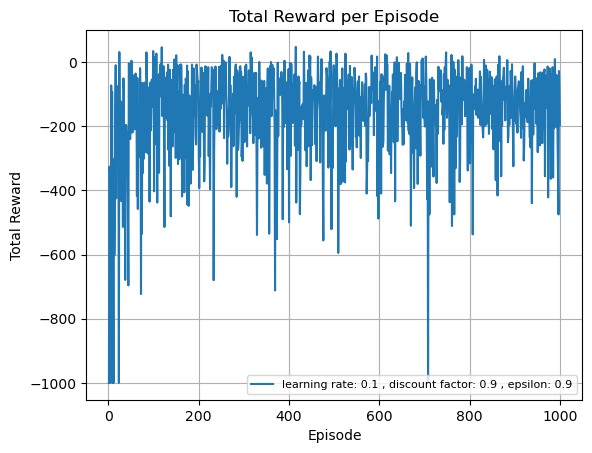

In [154]:
# Define constants variable
start_position = (9, 0)  
target_destination = (0, 9)  
num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.9

# Define the foun actions which are up, down, left, right
# Up = (-1, 0) as moving up will decrease the row index
# Down = (1, 0) as moving up will increase the row index
# Left = (0, -1) as moving up will decrease the column index
# Right = (0, 1) as moving up will increase the column index
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Initialize Q-table to store the estimated values of each action for each state in the warehouse 
Q_table = np.zeros((10, 10, 4))

# Define function to choose action by using epsilon-greedy
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        # Choose a random action to explore 
        return random.randint(0, len(actions) - 1)  
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q_table[state[0]][state[1]]) 

# Define function to update Q-table using Q-Learning
def update_q_table(state, action, next_state, reward):
    best_next_action = np.argmax(Q_table[next_state[0]][next_state[1]])
    Q_table[state[0]][state[1]][action] += learning_rate * (reward + discount_factor * Q_table[next_state[0]][next_state[1]][best_next_action] - Q_table[state[0]][state[1]][action])

# Define function to perform Q-learning
def Q_learning():
    
    # Initiate an empty list to store the total reward in each episode
    rewards_in_each_episode = []
    
    for episode in range(num_episodes):
        state = start_position
        total_reward = 0
        
        for step in range(max_steps_per_episode):
            action = choose_action(state)
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
            
            # Check if the state is valid
            # If the chosen action will move outside the grid or hit the shelve, it is a invalid state 
            if next_state[0] < 0 or next_state[0] >= 10 or next_state[1] < 0 or next_state[1] >= 10 or simulated_warehouse_environment[next_state[0]][next_state[1]] == -100:
                
                # Stay in the same grid or state
                next_state = state
            
            # Check if the agent arrives to the target destination 
            # If yes, give the agent a reward of 100
            if next_state == target_destination:
                reward = 100
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                break
            
            else:
                # Transit to the next state
                reward = -1
                total_reward += reward
                update_q_table(state, action, next_state, reward)
                state = next_state
        
        rewards_in_each_episode.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return rewards_in_each_episode

# Run Q-learning and collect the rewards
rewards_in_each_episode_eps3 = Q_learning()

# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_eps3, label = f'learning rate: {learning_rate} , discount factor: {discount_factor} , epsilon: {epsilon}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

#### Plot all these three together for the ease of comparison.

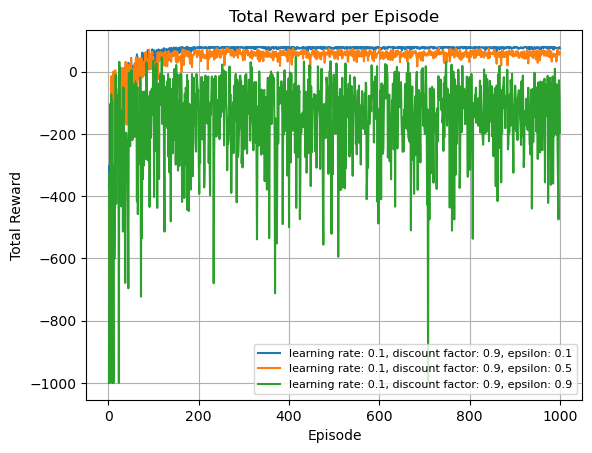

In [156]:
# Plot the learning curve (total reward accumulated per episode)
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_eps1, label = 'learning rate: 0.1, discount factor: 0.9, epsilon: 0.1')
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_eps2, label = 'learning rate: 0.1, discount factor: 0.9, epsilon: 0.5')
plt.plot(range(1, num_episodes + 1), rewards_in_each_episode_eps3, label = 'learning rate: 0.1, discount factor: 0.9, epsilon: 0.9')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(fontsize = '8', loc = 'lower right')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

## Advance

#### Comparison of DQN and DDQN

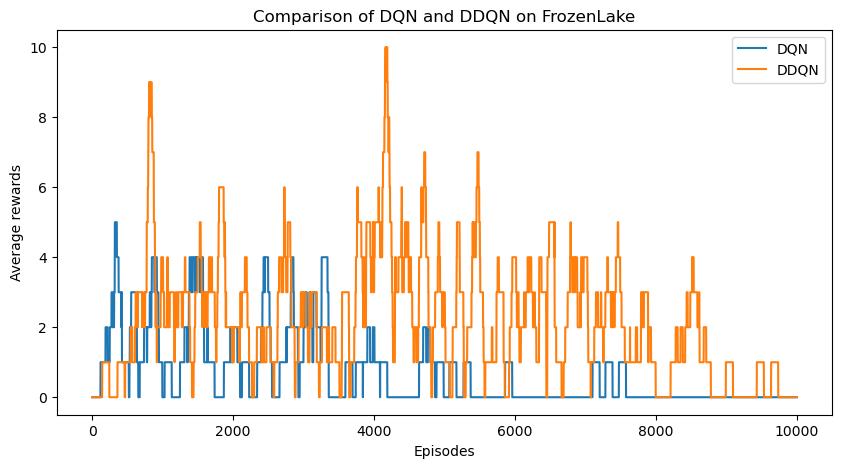

In [9]:
# Define the neural network for both DQN and DDQN
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

# Define experience replay memory
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# Define FrozenLake Deep Q-Learning class
class FrozenLakeDQN():
    
    # Initiate the parameters
    learning_rate_a = 0.1
    discount_factor_g = 0.9
    network_sync_rate = 10
    replay_memory_size = 1000
    mini_batch_size = 32
    loss_fn = nn.MSELoss()
    optimizer = None
    ACTIONS = ['L', 'D', 'R', 'U']

    def __init__(self, is_ddqn=False):
        self.is_ddqn = is_ddqn

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        epsilon = 1 
        memory = ReplayMemory(self.replay_memory_size)
        policy_dqn = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions)
        target_dqn = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions)
        target_dqn.load_state_dict(policy_dqn.state_dict())
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)
        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []
        step_count = 0
            
        for i in range(episodes):
            state = env.reset()[0]  
            terminated = False      
            truncated = False        

            while not terminated and not truncated:
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated)) 
                state = new_state
                step_count += 1

            if reward == 1:
                rewards_per_episode[i] = 1

            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.plot(sum_rewards)

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        num_states = policy_dqn.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max())

            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)
            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            target_q[action] = target
            target_q_list.append(target_q)
                
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))
        self.optimizer.zero_grad()
        loss.backward()

    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    def test(self, episodes, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        policy_dqn = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()

        for i in range(episodes):
            state = env.reset()[0]  
            terminated = False      
            truncated = False       

            while not terminated and not truncated:  
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                state, reward, terminated, truncated, _ = env.step(action)

        env.close()

if __name__ == '__main__':
    frozen_lake_dqn = FrozenLakeDQN()
    frozen_lake_ddqn = FrozenLakeDQN(is_ddqn=True)

    is_slippery = False
    episodes = 10000

    plt.figure(figsize=(10, 5))
    plt.title('Comparison of DQN and DDQN on FrozenLake')
    plt.xlabel('Episodes')
    plt.ylabel('Average rewards')

    frozen_lake_dqn.train(episodes, is_slippery=is_slippery)
    frozen_lake_ddqn.train(episodes, is_slippery=is_slippery)

    plt.legend(['DQN', 'DDQN'])
    plt.show()

#### Comparison of DQN with and without experience replay

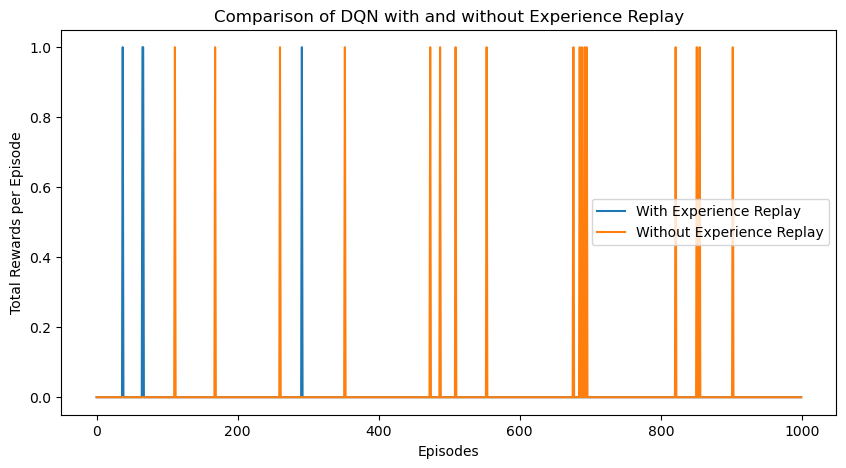

In [30]:
# Define the neural network for both DQN
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

# Define experience replay memory
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

class FrozenLakeDQN():
    
    learning_rate_a = 0.1         
    discount_factor_g = 0.9         
    network_sync_rate = 10         
    replay_memory_size = 1000       
    mini_batch_size = 32            
    
    # Neural Network
    loss_fn = nn.MSELoss()       
    optimizer = None                
    ACTIONS = ['L','D','R','U']     
    
    def __init__(self, use_experience_replay=True):
            self.use_experience_replay = use_experience_replay
            if self.use_experience_replay:
                self.replay_memory = ReplayMemory(self.replay_memory_size)
            self.rewards_per_episode = []

    def train(self, episodes, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        
        epsilon = 1 

        policy_dqn = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions)
        target_dqn = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)
        step_count = 0
            
        for i in range(episodes):
            state = env.reset()[0]  
            terminated = False      
            truncated = False        

            while not terminated and not truncated:
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                new_state, reward, terminated, truncated, _ = env.step(action)

                if self.use_experience_replay:
                    self.replay_memory.append((state, action, new_state, reward, terminated))
                    if len(self.replay_memory) > self.mini_batch_size:
                        mini_batch = self.replay_memory.sample(self.mini_batch_size)
                        self.optimize(mini_batch, policy_dqn, target_dqn)

                else:
                    if terminated: 
                        target = torch.FloatTensor([reward])
                    else:
                        with torch.no_grad():
                            target = torch.FloatTensor(
                                reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                            )

                    current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
                    target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
                    target_q[action] = target

                    loss = self.loss_fn(current_q, target_q)

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                state = new_state
                step_count += 1

            if reward == 1:
                rewards_per_episode[i] = 1

            if not self.use_experience_replay:
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

            epsilon = max(epsilon - 1/episodes, 0)
            self.rewards_per_episode.append(reward)

        env.close()

        return rewards_per_episode

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            target_q[action] = target
            target_q_list.append(target_q)

        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

if __name__ == '__main__':
    num_episodes = 1000
    
    frozen_lake_dqn_with_replay = FrozenLakeDQN(use_experience_replay=True)
    frozen_lake_dqn_no_replay = FrozenLakeDQN(use_experience_replay=False)
    
    # Train DQN with experience replay
    rewards_with_replay = frozen_lake_dqn_with_replay.train(num_episodes, is_slippery=False)
    # Train DQN without experience replay
    rewards_no_replay = frozen_lake_dqn_no_replay.train(num_episodes, is_slippery=False)

    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(num_episodes), rewards_with_replay, label='With Experience Replay')
    plt.plot(np.arange(num_episodes), rewards_no_replay, label='Without Experience Replay')
    plt.title('Comparison of DQN with and without Experience Replay')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards per Episode')
    plt.legend()
    plt.show()


### PPO

(RolloutWorker pid=29152) 2024-05-12 11:43:29,689	WARNING deprecation.py:50 -- DeprecationWarning: `num_envs_per_worker` has been deprecated. Use `AlgorithmConfig.num_envs_per_env_runner` instead. This will raise an error in the future!
2024-05-12 11:43:31,629	INFO trainable.py:161 -- Trainable.setup took 10.385 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-05-12 11:43:31,632	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Episode 1: Reward Mean = 17.857142857142858
Episode 2: Reward Mean = 16.533333333333335
Episode 3: Reward Mean = 19.894736842105264
Episode 4: Reward Mean = 22.772727272727273
Episode 5: Reward Mean = 24.04
Episode 6: Reward Mean = 27.321428571428573
Episode 7: Reward Mean = 29.6
Episode 8: Reward Mean = 30.727272727272727


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 9: Reward Mean = 32.51428571428571


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 10: Reward Mean = 33.026315789473685


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 11: Reward Mean = 33.5


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 12: Reward Mean = 34.38636363636363


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 13: Reward Mean = 34.583333333333336


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 14: Reward Mean = 34.6078431372549
Episode 15: Reward Mean = 35.0


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 16: Reward Mean = 35.45614035087719


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 17: Reward Mean = 35.7


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 18: Reward Mean = 36.25806451612903
Episode 19: Reward Mean = 37.0
Episode 20: Reward Mean = 37.333333333333336


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 21: Reward Mean = 38.298507462686565


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 22: Reward Mean = 40.128571428571426


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 23: Reward Mean = 40.583333333333336


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 24: Reward Mean = 40.84


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 25: Reward Mean = 40.78947368421053


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 26: Reward Mean = 41.848101265822784


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 27: Reward Mean = 42.048780487804876


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 28: Reward Mean = 41.96470588235294


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 29: Reward Mean = 42.06818181818182


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 30: Reward Mean = 41.51086956521739


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 31: Reward Mean = 40.88659793814433


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 32: Reward Mean = 40.63


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 33: Reward Mean = 41.34


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 34: Reward Mean = 41.75


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 35: Reward Mean = 42.44


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 36: Reward Mean = 42.28


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 37: Reward Mean = 41.78


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 38: Reward Mean = 41.54


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 39: Reward Mean = 40.61


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 40: Reward Mean = 39.94


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 41: Reward Mean = 39.92
Episode 42: Reward Mean = 39.53
Episode 43: Reward Mean = 39.15
Episode 44: Reward Mean = 38.92
Episode 45: Reward Mean = 38.2
Episode 46: Reward Mean = 38.12
Episode 47: Reward Mean = 37.61
Episode 48: Reward Mean = 36.87
Episode 49: Reward Mean = 34.94
Episode 50: Reward Mean = 34.34
Episode 51: Reward Mean = 32.73
Episode 52: Reward Mean = 32.91
Episode 53: Reward Mean = 32.05
Episode 54: Reward Mean = 32.05
Episode 55: Reward Mean = 32.24
Episode 56: Reward Mean = 32.52
Episode 57: Reward Mean = 32.62
Episode 58: Reward Mean = 32.54
Episode 59: Reward Mean = 32.57


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Episode 60: Reward Mean = 33.42
Episode 61: Reward Mean = 33.7
Episode 62: Reward Mean = 33.89
Episode 63: Reward Mean = 34.1
Episode 64: Reward Mean = 34.44
Episode 65: Reward Mean = 34.4
Episode 66: Reward Mean = 34.23
Episode 67: Reward Mean = 34.63
Episode 68: Reward Mean = 34.37
Episode 69: Reward Mean = 34.66
Episode 70: Reward Mean = 35.19
Episode 71: Reward Mean = 34.9
Episode 72: Reward Mean = 35.2
Episode 73: Reward Mean = 35.55
Episode 74: Reward Mean = 35.48
Episode 75: Reward Mean = 34.89
Episode 76: Reward Mean = 35.32
Episode 77: Reward Mean = 35.45
Episode 78: Reward Mean = 35.77
Episode 79: Reward Mean = 36.23
Episode 80: Reward Mean = 35.8
Episode 81: Reward Mean = 36.07
Episode 82: Reward Mean = 36.04
Episode 83: Reward Mean = 36.26
Episode 84: Reward Mean = 36.26
Episode 85: Reward Mean = 36.33
Episode 86: Reward Mean = 35.86
Episode 87: Reward Mean = 34.96
Episode 88: Reward Mean = 35.24
Episode 89: Reward Mean = 34.91
Episode 90: Reward Mean = 35.55
Episode 91: Re

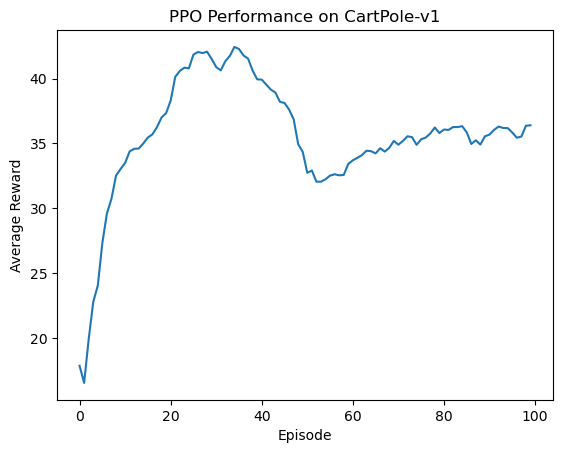

In [118]:
# Create the environment
def create_env(config):
    return EnvContext(env_name="CartPole-v1")

# Train the agent with performance logging
ppo_config = PPOConfig()
ppo_config = ppo_config.training(gamma = 0.9, lr = 0.1, kl_coeff = 0.3, train_batch_size = 128)
ppo_config = ppo_config.resources(num_gpus = 0)
ppo_config = ppo_config.env_runners(num_env_runners = 1)
ppo_algo = ppo_config.build(env = "CartPole-v1")

ppo_episode_rewards = []
for i in range(100): 
    ppo_result = ppo_algo.train()
    ppo_episode_rewards.append(ppo_result["episode_reward_mean"])
    print(f"Episode {i+1}: Reward Mean = {ppo_result['episode_reward_mean']}")

ppo_algo.stop()

plt.plot(ppo_episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("PPO Performance on CartPole-v1")
plt.show()